In [1]:
# =============================================================================
# PREDICCIÓN DE READMISIÓN DE PACIENTES DIABÉTICOS
# Estudiante: Juan Antonio Avalos Garcia
# Grupo: 9-C
# Tema: Diabetic Readmission Prediction
# =============================================================================

# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("✅ LIBRERÍAS IMPORTADAS CORRECTAMENTE")
print("="*80)


✅ LIBRERÍAS IMPORTADAS CORRECTAMENTE



📊 FASE 1: CARGA Y EXPLORACIÓN DE DATOS

✅ Dataset cargado exitosamente
   - Dimensiones: 101,766 filas × 50 columnas
   - Memoria utilizada: 192.87 MB

📋 INFORMACIÓN GENERAL DEL DATASET:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_ho

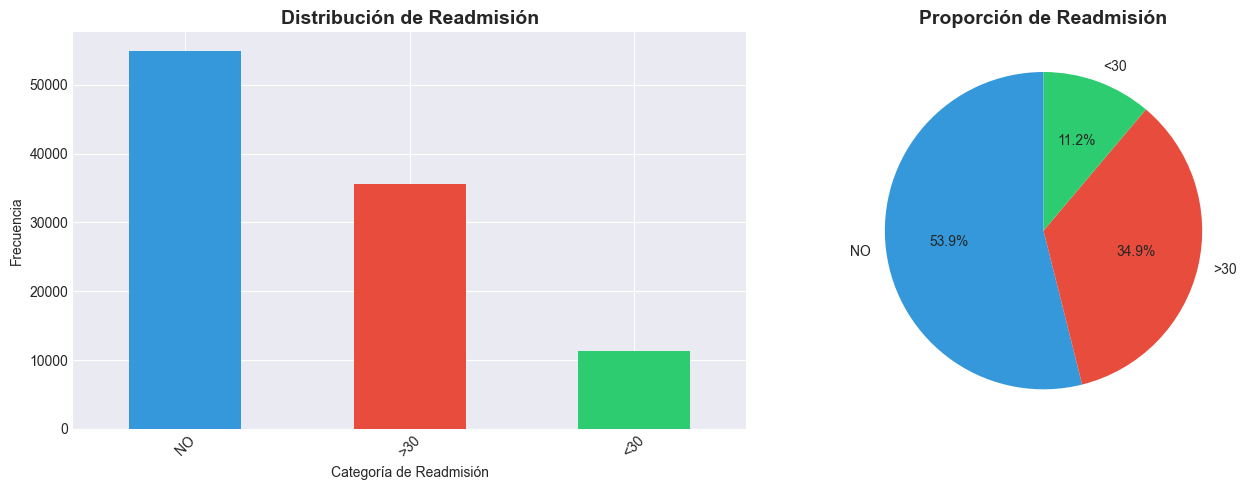

In [2]:

# =============================================================================
# 2. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# =============================================================================
print("\n" + "="*80)
print("📊 FASE 1: CARGA Y EXPLORACIÓN DE DATOS")
print("="*80)

# Cargar dataset
df = pd.read_csv('diabetic_data.csv')

print(f"\n✅ Dataset cargado exitosamente")
print(f"   - Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"   - Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Información básica
print(f"\n📋 INFORMACIÓN GENERAL DEL DATASET:")
print("-" * 80)
print(df.info())

print(f"\n🔍 PRIMERAS 5 FILAS DEL DATASET:")
print("-" * 80)
print(df.head())

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS (Variables Numéricas):")
print("-" * 80)
print(df.describe())

# Análisis de variable objetivo
print(f"\n🎯 ANÁLISIS DE VARIABLE OBJETIVO 'readmitted':")
print("-" * 80)
readmit_counts = df['readmitted'].value_counts()
print(readmit_counts)
print(f"\nPorcentajes:")
print(df['readmitted'].value_counts(normalize=True) * 100)

# Visualización de variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
readmit_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Distribución de Readmisión', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Categoría de Readmisión')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de pastel
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[1].pie(readmit_counts, labels=readmit_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporción de Readmisión', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('01_distribucion_variable_objetivo.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado: 01_distribucion_variable_objetivo.png")
plt.show()


🔍 FASE 2: ANÁLISIS EXPLORATORIO DE DATOS

📊 ANÁLISIS DE VALORES FALTANTES:
--------------------------------------------------------------------------------
          Columna  Valores Faltantes  Porcentaje
22  max_glu_serum              96420   94.746772
23      A1Cresult              84748   83.277322

🔍 ANÁLISIS DE VALORES '?' (Desconocidos):
--------------------------------------------------------------------------------
             Columna  Valores ?  Porcentaje
1             weight      98569   96.858479
3  medical_specialty      49949   49.082208
2         payer_code      40256   39.557416
0               race       2273    2.233555
6             diag_3       1423    1.398306
5             diag_2        358    0.351787
4             diag_1         21    0.020636

✅ Gráfico guardado: 02_valores_faltantes.png


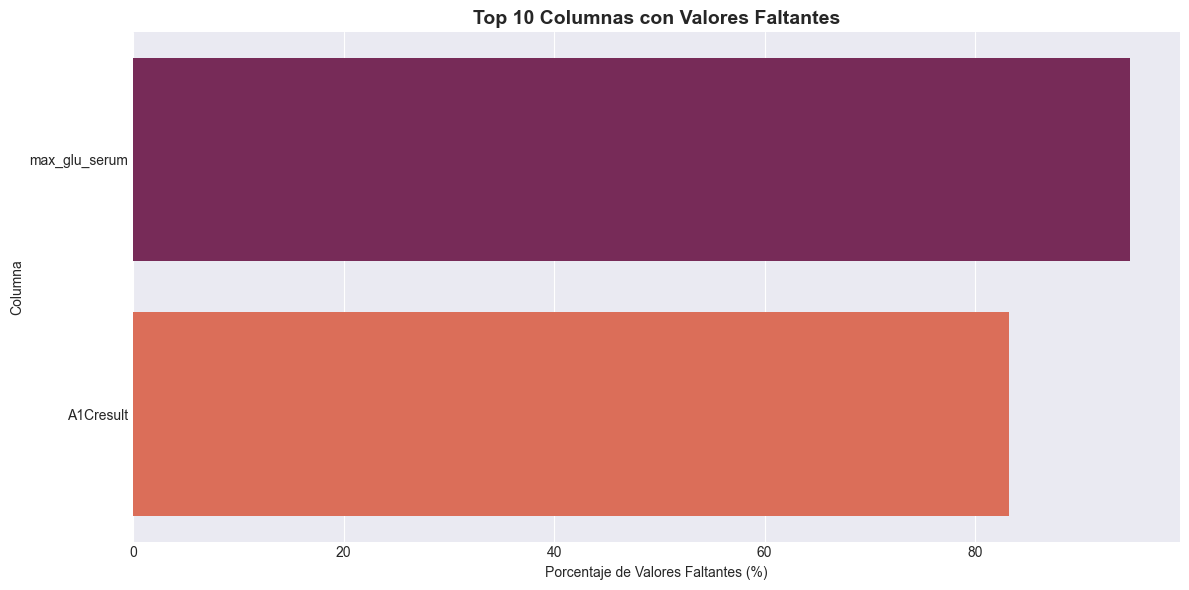

✅ Gráfico guardado: 03_distribucion_variables_numericas.png


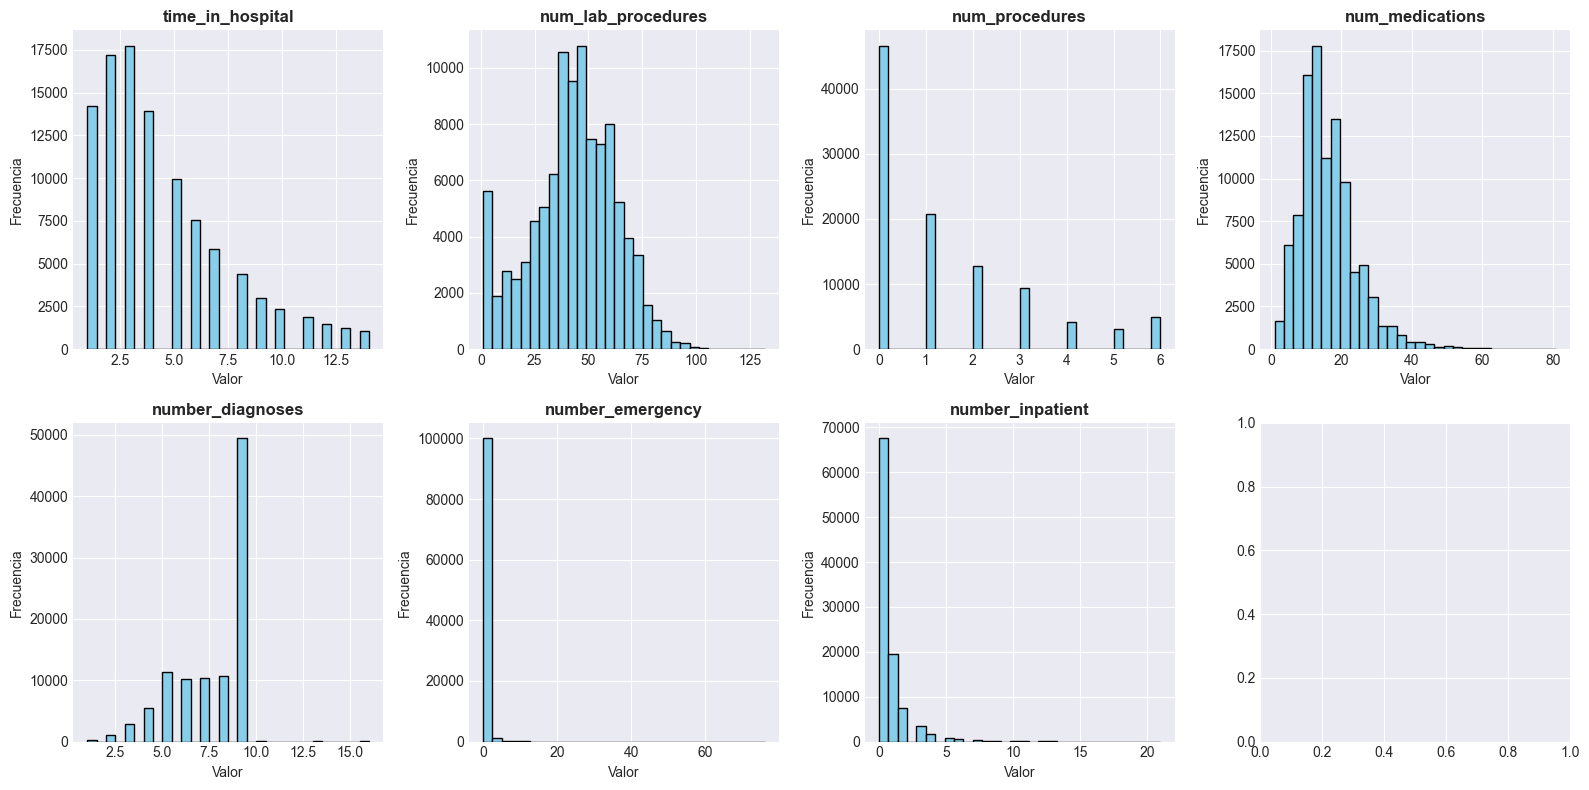

In [3]:

# =============================================================================
# 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# =============================================================================
print("\n" + "="*80)
print("🔍 FASE 2: ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# Análisis de valores faltantes
print(f"\n📊 ANÁLISIS DE VALORES FALTANTES:")
print("-" * 80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Valores Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
}).sort_values('Valores Faltantes', ascending=False)

print(missing_df[missing_df['Valores Faltantes'] > 0].head(10))

# Valores '?' en columnas categóricas
print(f"\n🔍 ANÁLISIS DE VALORES '?' (Desconocidos):")
print("-" * 80)
question_marks = {}
for col in df.select_dtypes(include='object').columns:
    count = (df[col] == '?').sum()
    if count > 0:
        question_marks[col] = count
        
question_df = pd.DataFrame(list(question_marks.items()), 
                          columns=['Columna', 'Valores ?'])
question_df['Porcentaje'] = (question_df['Valores ?'] / len(df)) * 100
question_df = question_df.sort_values('Valores ?', ascending=False)
print(question_df)

# Visualización de valores faltantes
fig, ax = plt.subplots(figsize=(12, 6))
top_missing = missing_df[missing_df['Valores Faltantes'] > 0].head(10)
sns.barplot(data=top_missing, x='Porcentaje', y='Columna', palette='rocket')
ax.set_title('Top 10 Columnas con Valores Faltantes', fontsize=14, fontweight='bold')
ax.set_xlabel('Porcentaje de Valores Faltantes (%)')
plt.tight_layout()
plt.savefig('02_valores_faltantes.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado: 02_valores_faltantes.png")
plt.show()

# Distribución de variables numéricas importantes
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                'num_medications', 'number_diagnoses', 'number_emergency', 
                'number_inpatient']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if col in df.columns:
        axes[idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('03_distribucion_variables_numericas.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: 03_distribucion_variables_numericas.png")
plt.show()

In [4]:

# =============================================================================
# 4. PREPROCESAMIENTO DE DATOS
# =============================================================================
print("\n" + "="*80)
print("🔧 FASE 3: PREPROCESAMIENTO DE DATOS")
print("="*80)

# Crear copia del dataset
df_processed = df.copy()

# 4.1 Crear variable objetivo binaria
print(f"\n📍 Paso 1: Creación de variable objetivo binaria")
df_processed['target'] = (df_processed['readmitted'] == '<30').astype(int)
print(f"✅ Variable 'target' creada:")
print(f"   - Clase 0 (No readmitido en <30 días): {(df_processed['target'] == 0).sum():,}")
print(f"   - Clase 1 (Readmitido en <30 días): {(df_processed['target'] == 1).sum():,}")
print(f"   - Ratio de desbalanceo: {(df_processed['target'] == 0).sum() / (df_processed['target'] == 1).sum():.2f}:1")

# 4.2 Eliminar columnas no útiles
print(f"\n📍 Paso 2: Eliminación de columnas no relevantes")
columns_to_drop = ['encounter_id', 'patient_nbr', 'readmitted', 'weight', 
                   'payer_code', 'medical_specialty']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"✅ Columnas eliminadas: {len(columns_to_drop)}")
for col in columns_to_drop:
    if col in df.columns:
        print(f"   - {col}")

# 4.3 Reemplazar '?' por NaN
print(f"\n📍 Paso 3: Manejo de valores '?' (desconocidos)")
categorical_cols = df_processed.select_dtypes(include=['object']).columns
total_replaced = 0
for col in categorical_cols:
    count = (df_processed[col] == '?').sum()
    df_processed[col] = df_processed[col].replace('?', np.nan)
    total_replaced += count
print(f"✅ Total de valores '?' reemplazados por NaN: {total_replaced:,}")

# 4.4 Separar características y objetivo
print(f"\n📍 Paso 4: Separación de características y variable objetivo")
X = df_processed.drop('target', axis=1)
y = df_processed['target']
print(f"✅ Datos separados:")
print(f"   - X (características): {X.shape}")
print(f"   - y (objetivo): {y.shape}")



🔧 FASE 3: PREPROCESAMIENTO DE DATOS

📍 Paso 1: Creación de variable objetivo binaria
✅ Variable 'target' creada:
   - Clase 0 (No readmitido en <30 días): 90,409
   - Clase 1 (Readmitido en <30 días): 11,357
   - Ratio de desbalanceo: 7.96:1

📍 Paso 2: Eliminación de columnas no relevantes
✅ Columnas eliminadas: 6
   - encounter_id
   - patient_nbr
   - readmitted
   - weight
   - payer_code
   - medical_specialty

📍 Paso 3: Manejo de valores '?' (desconocidos)
✅ Total de valores '?' reemplazados por NaN: 4,075

📍 Paso 4: Separación de características y variable objetivo
✅ Datos separados:
   - X (características): (101766, 44)
   - y (objetivo): (101766,)


In [5]:

# =============================================================================
# 5. IDENTIFICACIÓN Y TRANSFORMACIÓN DE CARACTERÍSTICAS
# =============================================================================
print("\n" + "="*80)
print("🔨 FASE 4: CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO")
print("="*80)

# Identificar tipos de características
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 CARACTERÍSTICAS IDENTIFICADAS:")
print(f"   - Numéricas: {len(numeric_features)}")
print(f"   - Categóricas: {len(categorical_features)}")
print(f"   - TOTAL: {len(numeric_features) + len(categorical_features)}")

print(f"\n🔢 Variables Numéricas ({len(numeric_features)}):")
for i, feat in enumerate(numeric_features, 1):
    print(f"   {i}. {feat}")

print(f"\n🔤 Variables Categóricas ({len(categorical_features)}):")
for i, feat in enumerate(categorical_features, 1):
    print(f"   {i}. {feat}")

# Construir pipeline de preprocesamiento
print(f"\n📍 Construcción de Pipeline de Transformación:")

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
print("   ✅ Pipeline numérico: Imputación (mediana) + Escalado (StandardScaler)")

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
print("   ✅ Pipeline categórico: Imputación (moda) + OneHotEncoding")

# Preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
print("   ✅ ColumnTransformer combinado creado exitosamente")



🔨 FASE 4: CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO

📊 CARACTERÍSTICAS IDENTIFICADAS:
   - Numéricas: 11
   - Categóricas: 33
   - TOTAL: 44

🔢 Variables Numéricas (11):
   1. admission_type_id
   2. discharge_disposition_id
   3. admission_source_id
   4. time_in_hospital
   5. num_lab_procedures
   6. num_procedures
   7. num_medications
   8. number_outpatient
   9. number_emergency
   10. number_inpatient
   11. number_diagnoses

🔤 Variables Categóricas (33):
   1. race
   2. gender
   3. age
   4. diag_1
   5. diag_2
   6. diag_3
   7. max_glu_serum
   8. A1Cresult
   9. metformin
   10. repaglinide
   11. nateglinide
   12. chlorpropamide
   13. glimepiride
   14. acetohexamide
   15. glipizide
   16. glyburide
   17. tolbutamide
   18. pioglitazone
   19. rosiglitazone
   20. acarbose
   21. miglitol
   22. troglitazone
   23. tolazamide
   24. examide
   25. citoglipton
   26. insulin
   27. glyburide-metformin
   28. glipizide-metformin
   29. glimepiride-pioglitazone
   

In [6]:

# =============================================================================
# 6. DIVISIÓN DE DATOS
# =============================================================================
print("\n" + "="*80)
print("📂 FASE 5: DIVISIÓN DE DATOS (TRAIN-TEST SPLIT)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n✅ Datos divididos (80% Train - 20% Test):")
print(f"\n📊 Conjunto de ENTRENAMIENTO:")
print(f"   - X_train: {X_train.shape}")
print(f"   - y_train: {y_train.shape}")
print(f"   - Distribución de clases:")
print(f"     • Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"     • Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

print(f"\n📊 Conjunto de PRUEBA:")
print(f"   - X_test: {X_test.shape}")
print(f"   - y_test: {y_test.shape}")
print(f"   - Distribución de clases:")
print(f"     • Clase 0: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")
print(f"     • Clase 1: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")


📂 FASE 5: DIVISIÓN DE DATOS (TRAIN-TEST SPLIT)

✅ Datos divididos (80% Train - 20% Test):

📊 Conjunto de ENTRENAMIENTO:
   - X_train: (81412, 44)
   - y_train: (81412,)
   - Distribución de clases:
     • Clase 0: 72,326 (88.84%)
     • Clase 1: 9,086 (11.16%)

📊 Conjunto de PRUEBA:
   - X_test: (20354, 44)
   - y_test: (20354,)
   - Distribución de clases:
     • Clase 0: 18,083 (88.84%)
     • Clase 1: 2,271 (11.16%)


In [7]:

# =============================================================================
# 7. DEFINICIÓN DE MODELOS Y HIPERPARÁMETROS (OPTIMIZADO PARA MEMORIA)
# =============================================================================
print("\n" + "="*80)
print("🤖 FASE 6: CONFIGURACIÓN DE MODELOS DE MACHINE LEARNING")
print("="*80)
print("⚠️  MODO OPTIMIZADO PARA SISTEMAS CON MEMORIA LIMITADA")

# Definir modelos con configuraciones ligeras
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=500))
    ]),
    
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', 
                                             n_estimators=50, max_depth=10, n_jobs=1))
    ]),
    
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=3))
    ])
}

# Grids MUY REDUCIDOS (solo 2-4 combinaciones por modelo)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [1, 10]  # Solo 2 valores
    },
    
    'Random Forest': {
        'classifier__n_estimators': [50, 100]  # Solo 2 valores
    },
    
    'Gradient Boosting': {
        'classifier__learning_rate': [0.1],  # Solo 1 valor
        'classifier__n_estimators': [50, 100]  # Solo 2 valores
    }
}

print(f"\n✅ {len(models)} Modelos configurados (Optimizados para memoria):")
for i, model_name in enumerate(models.keys(), 1):
    n_combinations = np.prod([len(v) for v in param_grids[model_name].values()])
    print(f"\n   {i}. {model_name}")
    print(f"      - Hiperparámetros a evaluar: {param_grids[model_name]}")
    print(f"      - Combinaciones totales: {n_combinations}")
    print(f"      - Fits totales (CV=2): {n_combinations * 2}")


🤖 FASE 6: CONFIGURACIÓN DE MODELOS DE MACHINE LEARNING
⚠️  MODO OPTIMIZADO PARA SISTEMAS CON MEMORIA LIMITADA

✅ 3 Modelos configurados (Optimizados para memoria):

   1. Logistic Regression
      - Hiperparámetros a evaluar: {'classifier__C': [1, 10]}
      - Combinaciones totales: 2
      - Fits totales (CV=2): 4

   2. Random Forest
      - Hiperparámetros a evaluar: {'classifier__n_estimators': [50, 100]}
      - Combinaciones totales: 2
      - Fits totales (CV=2): 4

   3. Gradient Boosting
      - Hiperparámetros a evaluar: {'classifier__learning_rate': [0.1], 'classifier__n_estimators': [50, 100]}
      - Combinaciones totales: 2
      - Fits totales (CV=2): 4


In [8]:
# =============================================================================
# 8. ENTRENAMIENTO DE MODELOS CON GRID SEARCH (OPTIMIZADO)
# =============================================================================
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

print("\n" + "="*80)
print("🚀 FASE 7: ENTRENAMIENTO DE MODELOS (OPTIMIZADO PARA MEMORIA)")
print("="*80)

best_models = {}
training_results = []

# SOLO 2 FOLDS para ahorrar memoria
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

print(f"\n📊 Configuración de Validación Cruzada:")
print(f"   - Método: StratifiedKFold")
print(f"   - Número de folds: 2 (optimizado)")
print(f"   - Métrica de optimización: ROC-AUC")
print(f"   - n_jobs: 1 (sin paralelización para ahorrar memoria)")

for i, (model_name, model_pipeline) in enumerate(models.items(), 1):
    print(f"\n{'='*80}")
    print(f"🔄 MODELO {i}/{len(models)}: {model_name}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    try:
        print(f"   ⏳ Entrenando con Grid Search (modo ligero)...")
        
        grid_search = GridSearchCV(
            estimator=model_pipeline,
            param_grid=param_grids[model_name],
            cv=cv,
            scoring='roc_auc',
            n_jobs=1,  # SIN PARALELIZACIÓN
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        
        training_time = time.time() - start_time
        
        print(f"\n   ✅ Entrenamiento completado exitosamente")
        print(f"   📊 RESULTADOS:")
        print(f"      - Mejor AUC (CV): {grid_search.best_score_:.4f}")
        print(f"      - Mejores hiperparámetros: {grid_search.best_params_}")
        print(f"      - Tiempo de entrenamiento: {training_time:.2f} segundos")
        
        training_results.append({
            'Modelo': model_name,
            'AUC_CV': grid_search.best_score_,
            'Tiempo': training_time,
            'Mejores_Params': str(grid_search.best_params_)
        })
        
    except Exception as e:
        print(f"   ❌ ERROR en {model_name}: {str(e)}")
        print(f"   💡 Intentando entrenamiento directo sin GridSearch...")
        
        try:
            model_pipeline.fit(X_train, y_train)
            best_models[model_name] = model_pipeline
            training_time = time.time() - start_time
            
            # Calcular AUC en train
            y_train_pred_proba = model_pipeline.predict_proba(X_train)[:, 1]
            train_auc = roc_auc_score(y_train, y_train_pred_proba)
            
            print(f"   ✅ Entrenamiento directo exitoso")
            print(f"      - AUC (Train): {train_auc:.4f}")
            print(f"      - Tiempo: {training_time:.2f} segundos")
            
            training_results.append({
                'Modelo': model_name,
                'AUC_CV': train_auc,
                'Tiempo': training_time,
                'Mejores_Params': 'Default'
            })
        except Exception as e2:
            print(f"   ❌ Fallo completo: {str(e2)}")

# ===========================
# 📊 RESUMEN FINAL
# ===========================
print(f"\n{'='*80}")
print(f"📊 RESUMEN DE ENTRENAMIENTO")
print(f"{'='*80}")
if training_results:
    training_df = pd.DataFrame(training_results)
    print(training_df.to_string(index=False))
else:
    print("⚠️  No se pudieron entrenar modelos")



🚀 FASE 7: ENTRENAMIENTO DE MODELOS (OPTIMIZADO PARA MEMORIA)

📊 Configuración de Validación Cruzada:
   - Método: StratifiedKFold
   - Número de folds: 2 (optimizado)
   - Métrica de optimización: ROC-AUC
   - n_jobs: 1 (sin paralelización para ahorrar memoria)

🔄 MODELO 1/3: Logistic Regression
   ⏳ Entrenando con Grid Search (modo ligero)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits

   ✅ Entrenamiento completado exitosamente
   📊 RESULTADOS:
      - Mejor AUC (CV): 0.6258
      - Mejores hiperparámetros: {'classifier__C': 1}
      - Tiempo de entrenamiento: 209.05 segundos

🔄 MODELO 2/3: Random Forest
   ⏳ Entrenando con Grid Search (modo ligero)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits

   ✅ Entrenamiento completado exitosamente
   📊 RESULTADOS:
      - Mejor AUC (CV): 0.6401
      - Mejores hiperparámetros: {'classifier__n_estimators': 100}
      - Tiempo de entrenamiento: 71.80 segundos

🔄 MODELO 3/3: Gradient Boosting
   ⏳ Entrenando con Gr

In [26]:
# =============================================================================
# 9. SELECCIÓN DEL MEJOR MODELO
# =============================================================================
print("\n" + "="*80)
print("🏆 FASE 9: SELECCIÓN DEL MEJOR MODELO")
print("="*80)

try:
    # Verificamos que haya resultados válidos
    if not results:
        raise ValueError("No se encontraron resultados de evaluación. Ejecuta la Fase 8 primero.")

    # Elegir el modelo con mejor AUC
    best_model_name = max(results, key=lambda name: results[name]['auc'])
    best_metrics = results[best_model_name]
    best_model = best_models[best_model_name]

    # Mostrar resumen del mejor modelo
    print(f"\n✅ Mejor modelo seleccionado: {best_model_name}")
    print(f"   ├─ Accuracy:  {best_metrics['accuracy']:.4f}")
    print(f"   ├─ Precision: {best_metrics['precision']:.4f}")
    print(f"   ├─ Recall:    {best_metrics['recall']:.4f}")
    print(f"   ├─ F1-Score:  {best_metrics['f1_score']:.4f}")
    print(f"   └─ AUC-ROC:   {best_metrics['auc']:.4f}")

    # Confirmación visual
    print(f"\n🏁 El modelo '{best_model_name}' será guardado como el mejor modelo para despliegue.")

except Exception as e:
    print(f"\n❌ ERROR al seleccionar el mejor modelo: {e}")
    import traceback
    traceback.print_exc()



🏆 FASE 9: SELECCIÓN DEL MEJOR MODELO

✅ Mejor modelo seleccionado: Gradient Boosting
   ├─ Accuracy:  0.8885
   ├─ Precision: 0.5294
   ├─ Recall:    0.0079
   ├─ F1-Score:  0.0156
   └─ AUC-ROC:   0.6776

🏁 El modelo 'Gradient Boosting' será guardado como el mejor modelo para despliegue.



📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN
✅ Gráfico guardado: 04_comparacion_metricas.png


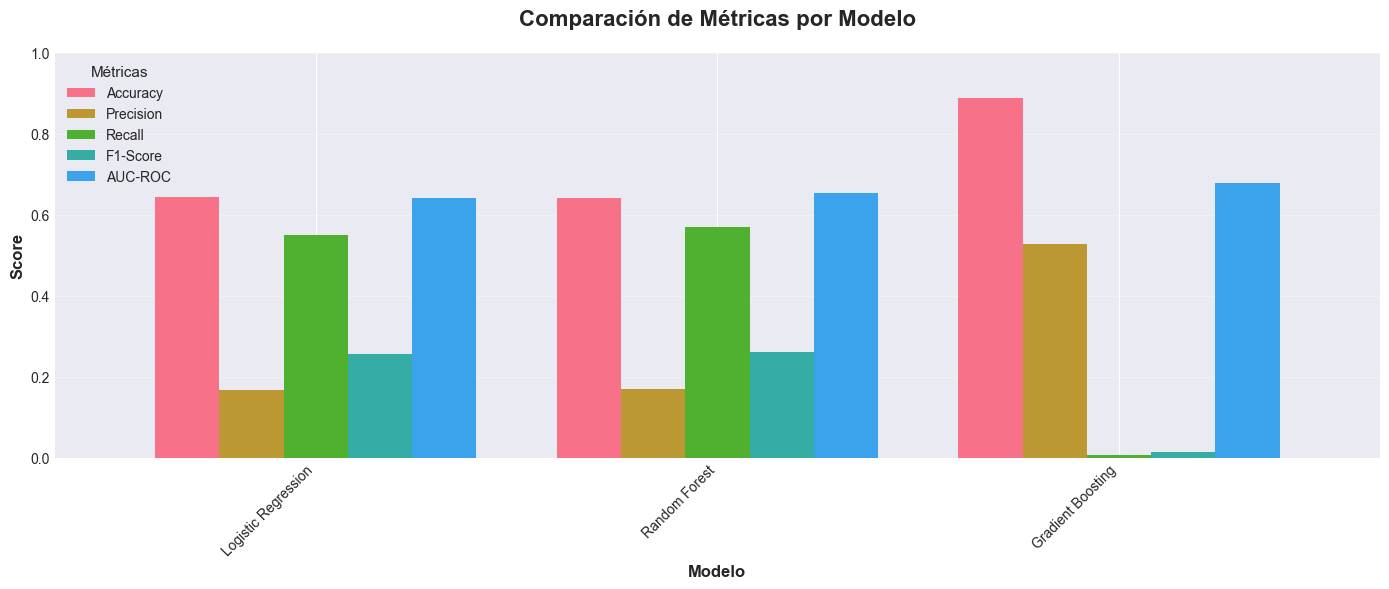

✅ Gráfico guardado: 05_matrices_confusion.png


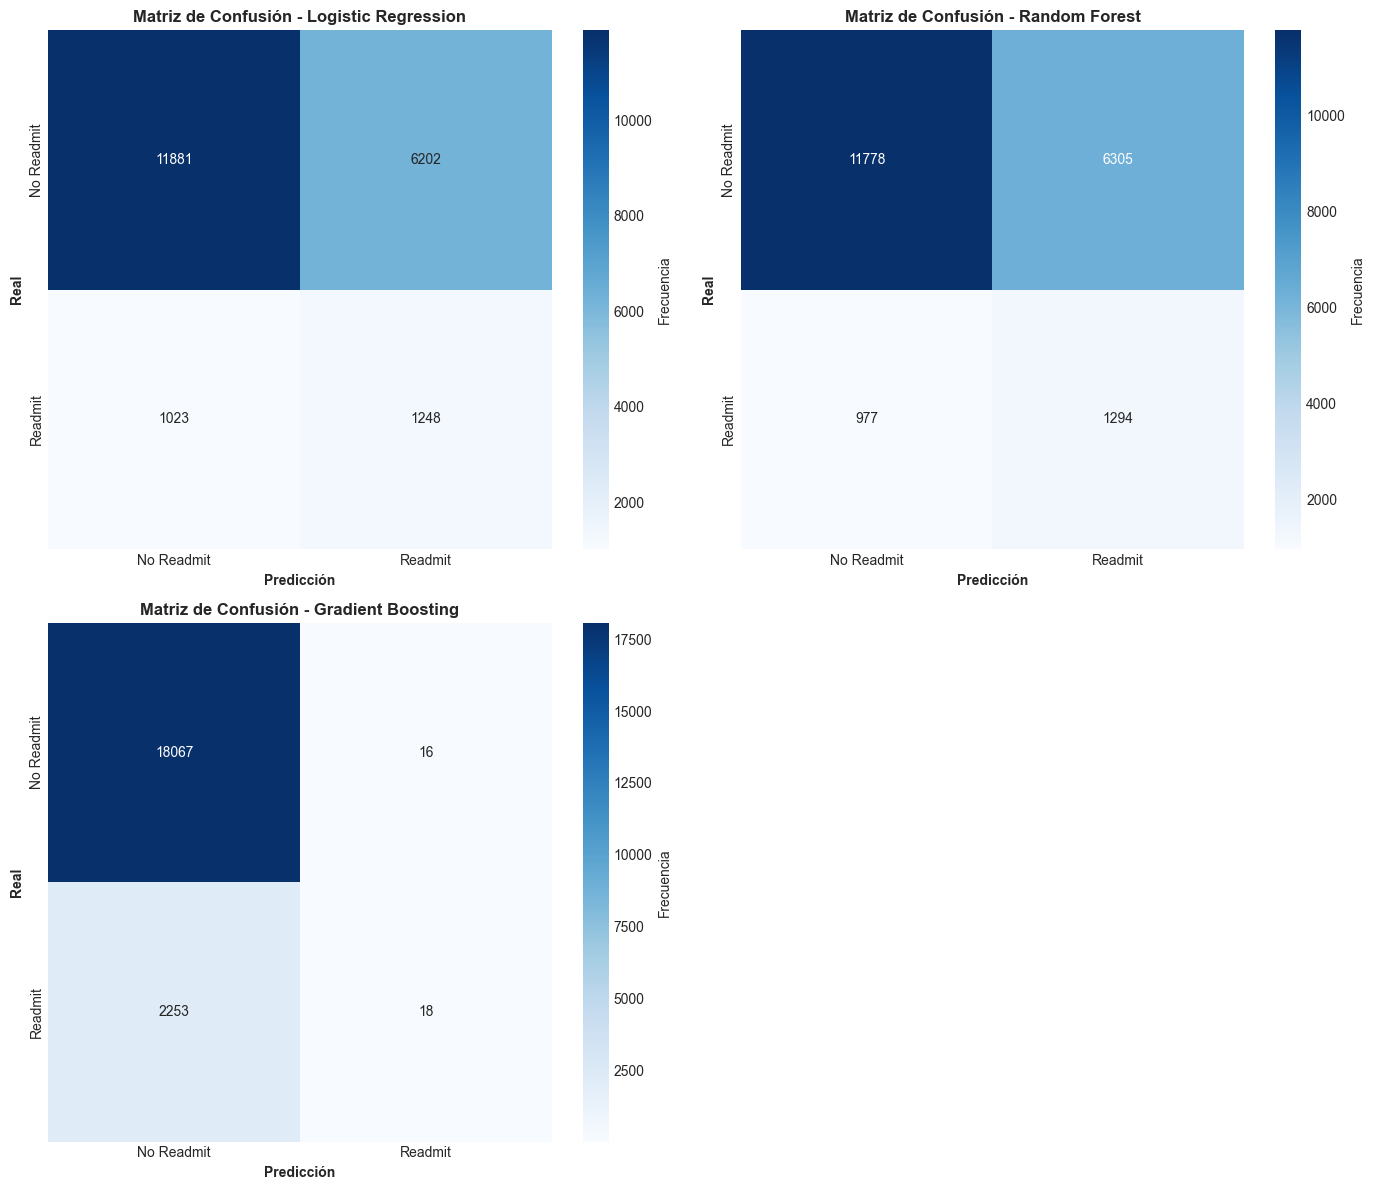

✅ Gráfico guardado: 06_curvas_roc.png


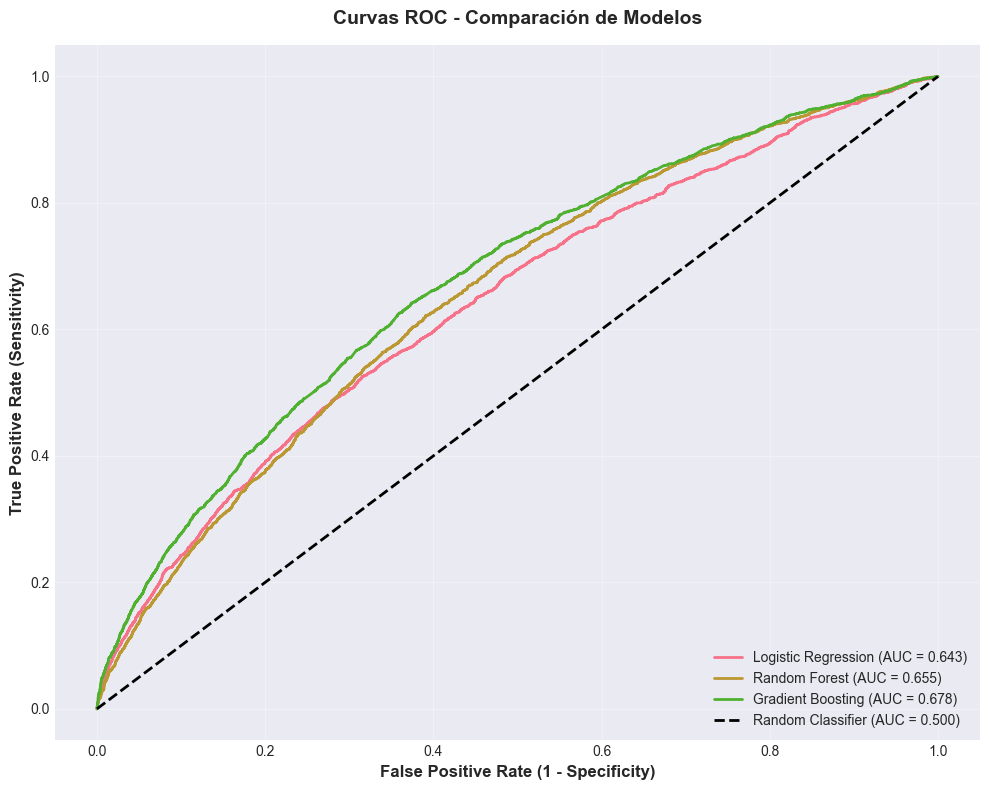

In [27]:

# =============================================================================
# 10. VISUALIZACIONES DE EVALUACIÓN
# =============================================================================
print("\n" + "="*80)
print("📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN")
print("="*80)

if not results:
    print("⚠️  No hay resultados para visualizar")
else:
    # Comparación de métricas
    metrics_comparison = pd.DataFrame({
        'Modelo': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'Precision': [results[m]['precision'] for m in results.keys()],
        'Recall': [results[m]['recall'] for m in results.keys()],
        'F1-Score': [results[m]['f1_score'] for m in results.keys()],
        'AUC-ROC': [results[m]['auc'] for m in results.keys()]
    })

    # Gráfico de comparación de métricas
    fig, ax = plt.subplots(figsize=(14, 6))
    metrics_comparison.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(
        kind='bar', ax=ax, width=0.8)
    ax.set_title('Comparación de Métricas por Modelo', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.legend(title='Métricas', fontsize=10, title_fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('04_comparacion_metricas.png', dpi=300, bbox_inches='tight')
    print("✅ Gráfico guardado: 04_comparacion_metricas.png")
    plt.show()

    # Matrices de confusión
    n_models = len(results)
    n_cols = min(2, n_models)
    n_rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    for idx, (model_name, result) in enumerate(results.items()):
        cm = result['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    cbar_kws={'label': 'Frecuencia'})
        axes[idx].set_title(f'Matriz de Confusión - {model_name}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicción', fontweight='bold')
        axes[idx].set_ylabel('Real', fontweight='bold')
        axes[idx].set_xticklabels(['No Readmit', 'Readmit'])
        axes[idx].set_yticklabels(['No Readmit', 'Readmit'])

    # Ocultar ejes vacíos
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('05_matrices_confusion.png', dpi=300, bbox_inches='tight')
    print("✅ Gráfico guardado: 05_matrices_confusion.png")
    plt.show()

    # Curvas ROC
    fig, ax = plt.subplots(figsize=(10, 8))

    for model_name in results.keys():
        y_pred_proba = all_predictions[model_name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results[model_name]['auc']
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=2)
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
    ax.set_title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('06_curvas_roc.png', dpi=300, bbox_inches='tight')
    print("✅ Gráfico guardado: 06_curvas_roc.png")
    plt.show()

In [28]:

# =============================================================================
# SECCIÓN 11: GUARDAR MODELO
# =============================================================================

print("\n" + "="*80)
print("💾 GUARDANDO MODELO Y RECURSOS")
print("="*80)

if 'best_model' not in locals() or 'results' not in locals() or not results:
    print("\n❌ ERROR: No se puede guardar. Falta información.")
    print("\n🔍 DIAGNÓSTICO:")
    print(f"   - best_models (entrenamiento): {'✅' if 'best_models' in locals() and best_models else '❌'}")
    print(f"   - results (evaluación): {'✅' if 'results' in locals() and results else '❌'}")
    print(f"   - best_model (selección): {'✅' if 'best_model' in locals() else '❌'}")
    
    print("\n💡 SOLUCIÓN:")
    print("   Ejecuta estas secciones en orden:")
    print("   1. Sección 7: Entrenamiento → Crea 'best_models'")
    print("   2. Sección 8: Evaluación → Crea 'results'")
    print("   3. Sección 9: Selección → Crea 'best_model'")
    print("   4. Sección 11: Guardado → Usa las variables anteriores")
    
else:
    try:
        # Guardar el mejor modelo
        joblib.dump(best_model, 'diabetes_best_model.pkl')
        print(f"\n✅ Modelo guardado: diabetes_best_model.pkl")
        print(f"   - Tipo: {best_model_name}")
        print(f"   - AUC: {best_metrics['auc']:.4f}")
        
        # Guardar información de características
        feature_info = {
            'numeric_features': numeric_features,
            'categorical_features': categorical_features,
            'all_features': list(X.columns)
        }
        joblib.dump(feature_info, 'feature_info.pkl')
        print(f"\n✅ Características guardadas: feature_info.pkl")
        print(f"   - Numéricas: {len(numeric_features)}")
        print(f"   - Categóricas: {len(categorical_features)}")
        
        # Guardar resultados
        model_results = {
            'best_model_name': best_model_name,
            'metrics': {
                'accuracy': float(best_metrics['accuracy']),
                'precision': float(best_metrics['precision']),
                'recall': float(best_metrics['recall']),
                'f1_score': float(best_metrics['f1_score']),
                'auc': float(best_metrics['auc'])
            },
            'confusion_matrix': best_metrics['confusion_matrix'].tolist(),
            'all_models': {name: {'auc': results[name]['auc']} for name in results.keys()}
        }
        joblib.dump(model_results, 'model_results.pkl')
        print(f"\n✅ Resultados guardados: model_results.pkl")
        
        # Guardar preprocesador
        joblib.dump(preprocessor, 'preprocessor.pkl')
        print(f"\n✅ Preprocesador guardado: preprocessor.pkl")
        
        # Resumen final
        print(f"\n{'='*80}")
        print("🎉 ¡GUARDADO EXITOSO!")
        print("="*80)
        print(f"\n📦 Archivos generados:")
        print("   1. diabetes_best_model.pkl")
        print("   2. feature_info.pkl")
        print("   3. model_results.pkl")
        print("   4. preprocessor.pkl")
        
        print(f"\n🏆 RESUMEN DEL MEJOR MODELO:")
        print(f"   Modelo: {best_model_name}")
        print(f"   AUC: {best_metrics['auc']:.4f}")
        
        print(f"\n📊 COMPARACIÓN DE TODOS LOS MODELOS:")
        for name in results.keys():
            print(f"   {name}: AUC = {results[name]['auc']:.4f}")
        
        print(f"\n✅ Todo listo para la Parte 2: Despliegue Web")
        
    except Exception as e:
        print(f"\n❌ ERROR al guardar: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("📝 FIN DEL PROCESO")
print("="*80)


💾 GUARDANDO MODELO Y RECURSOS

✅ Modelo guardado: diabetes_best_model.pkl
   - Tipo: Gradient Boosting
   - AUC: 0.6776

✅ Características guardadas: feature_info.pkl
   - Numéricas: 11
   - Categóricas: 33

✅ Resultados guardados: model_results.pkl

✅ Preprocesador guardado: preprocessor.pkl

🎉 ¡GUARDADO EXITOSO!

📦 Archivos generados:
   1. diabetes_best_model.pkl
   2. feature_info.pkl
   3. model_results.pkl
   4. preprocessor.pkl

🏆 RESUMEN DEL MEJOR MODELO:
   Modelo: Gradient Boosting
   AUC: 0.6776

📊 COMPARACIÓN DE TODOS LOS MODELOS:
   Logistic Regression: AUC = 0.6426
   Random Forest: AUC = 0.6547
   Gradient Boosting: AUC = 0.6776

✅ Todo listo para la Parte 2: Despliegue Web

📝 FIN DEL PROCESO


In [29]:

# =============================================================================
# 12. PERSISTENCIA DEL MODELO Y RECURSOS (PARTE 2)
# =============================================================================
print("\n" + "="*80)
print("💾 FASE 10: GUARDANDO MODELO Y RECURSOS PARA DESPLIEGUE")
print("="*80)

if not results:
    print("⚠️  No hay modelos para guardar. Revisa los errores anteriores.")
else:
    try:
        # Guardar el mejor modelo
        joblib.dump(best_model, 'diabetes_best_model.pkl')
        print(f"✅ Mejor modelo guardado: diabetes_best_model.pkl")
        print(f"   - Modelo: {best_model_name}")
        print(f"   - AUC: {best_metrics['auc']:.4f}")
        
        # Guardar información de características
        feature_info = {
            'numeric_features': numeric_features,
            'categorical_features': categorical_features,
            'all_features': list(X.columns),
            'feature_names_original': list(X.columns)
        }
        joblib.dump(feature_info, 'feature_info.pkl')
        print(f"\n✅ Información de características guardada: feature_info.pkl")
        print(f"   - Características numéricas: {len(numeric_features)}")
        print(f"   - Características categóricas: {len(categorical_features)}")
        
        # Guardar resultados y métricas
        model_results = {
            'best_model_name': best_model_name,
            'metrics': {
                'accuracy': best_metrics['accuracy'],
                'precision': best_metrics['precision'],
                'recall': best_metrics['recall'],
                'f1_score': best_metrics['f1_score'],
                'auc': best_metrics['auc']
            },
            'confusion_matrix': best_metrics['confusion_matrix'].tolist(),
            'all_models_comparison': metrics_comparison.to_dict() if 'metrics_comparison' in locals() else {}
        }
        joblib.dump(model_results, 'model_results.pkl')
        print(f"\n✅ Resultados del modelo guardados: model_results.pkl")
        
        # Guardar preprocessor por separado (útil para la app web)
        joblib.dump(preprocessor, 'preprocessor.pkl')
        print(f"\n✅ Preprocesador guardado: preprocessor.pkl")
        
        print(f"\n{'='*80}")
        print("📦 ARCHIVOS GENERADOS PARA DESPLIEGUE:")
        print("="*80)
        print("   1. diabetes_best_model.pkl      → Modelo completo (con pipeline)")
        print("   2. feature_info.pkl              → Información de características")
        print("   3. model_results.pkl             → Métricas y resultados")
        print("   4. preprocessor.pkl              → Preprocesador independiente")
        print("   5. 01-06_*.png                   → Gráficos de análisis")
        
    except Exception as e:
        print(f"❌ Error guardando archivos: {str(e)}")


💾 FASE 10: GUARDANDO MODELO Y RECURSOS PARA DESPLIEGUE
✅ Mejor modelo guardado: diabetes_best_model.pkl
   - Modelo: Gradient Boosting
   - AUC: 0.6776

✅ Información de características guardada: feature_info.pkl
   - Características numéricas: 11
   - Características categóricas: 33

✅ Resultados del modelo guardados: model_results.pkl

✅ Preprocesador guardado: preprocessor.pkl

📦 ARCHIVOS GENERADOS PARA DESPLIEGUE:
   1. diabetes_best_model.pkl      → Modelo completo (con pipeline)
   2. feature_info.pkl              → Información de características
   3. model_results.pkl             → Métricas y resultados
   4. preprocessor.pkl              → Preprocesador independiente
   5. 01-06_*.png                   → Gráficos de análisis
